In [8]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import iris
import iris.quickplot as qplt
import iris.plot as iplt
from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import Utils.iris_utils
import Utils.Gridding
from Utils.nc_processing import *
from Utils.analysis import * 
#from Utils.plotting import *
import esmvalcore.preprocessor
import xesmf as xe
import warnings
%matplotlib inline
import seaborn as sns
import scipy
#sns.set()

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False):
    df_hist = df[df['Experiment']=='historical']
    df_hist = df_hist[df_hist['Year'] > t_bnds[0]][df_hist['Year'] < t_bnds[1]]
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['Unnamed: 0', 'Year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()


baseline_name_changes = {'No_arctic_temp':'No_arctic_base_tas',
                         'Global_temp':'Global_base_tas',
                        }


in_folder_tas = 'int_outputs/temperature_v2/'
exp='ssp370'
tas_df = make_df(in_folder_tas)



In [9]:
tas_df

,year,no_arctic_tas,world_tas,Model,Experiment,Ensemble_member
0,2015,289.370770,288.184997,TaiESM1,ssp370,r1i1p1f1
1,2016,289.364955,288.112963,TaiESM1,ssp370,r1i1p1f1
2,2017,289.055367,287.827384,TaiESM1,ssp370,r1i1p1f1
3,2018,289.175567,287.892981,TaiESM1,ssp370,r1i1p1f1
4,2019,289.471042,288.260987,TaiESM1,ssp370,r1i1p1f1
...,...,...,...,...,...,...
3803,2010,289.238856,288.186039,AWI-CM-1-1-MR,historical,r1i1p1f1
3804,2011,289.077905,287.985567,AWI-CM-1-1-MR,historical,r1i1p1f1
3805,2012,289.189521,288.100637,AWI-CM-1-1-MR,historical,r1i1p1f1
3806,2013,289.160650,288.069818,AWI-CM-1-1-MR,historical,r1i1p1f1


In [10]:

### lose monthly resolution and ensemble members as they are not needed
#tas_df = tas_df.groupby(['Year', 'Experiment', 'Model']).mean().reset_index() 
tas_df = tas_df.groupby(['Year', 'Experiment', 'Model']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900])
tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model'])
tas_df['No_arctic_tas_anom'] = tas_df['No_arctic_temp'] - tas_df['No_arctic_base_tas']
tas_df['Global_tas_anom'] = tas_df['Global_temp'] - tas_df['Global_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()


KeyError: 'Year'

In [2]:
models

array(['ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'CNRM-CM6-1', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'KACE-1-0-G', 'MRI-ESM2-0', 'NorESM2-MM',
       'TaiESM1', 'UKESM1-0-LL', 'UKESM1-1-LL'], dtype=object)

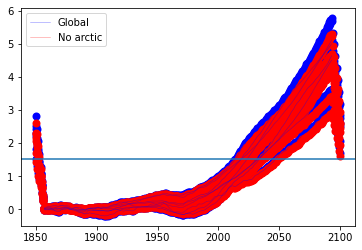

In [7]:
window=15

for model in models:
    df = tas_df[tas_df['Model']==model]
    plt.plot(df['Year'], df['Global_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=0.5, linewidth=0.5, label='Global')
    plt.plot(df['Year'], df['No_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=0.5, linewidth=0.5, label='No arctic')

df = tas_df.groupby(['Model', 'Year']).mean().reset_index() 
plt.scatter(df['Year'], df['Global_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=1, linewidth=2, label='Global')
plt.scatter(df['Year'], df['No_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=1, linewidth=2, label='No arctic')
legend_without_duplicate_labels(plt.gca())
#plt.xlim(1980,2050)
plt.axhline(1.5)


In [63]:
df

,Model,Year,Unnamed: 0,No_arctic_temp,Global_temp,No_arctic_base_tas,Global_base_tas,No_arctic_tas_anom,Global_tas_anom
0,CNRM-CM6-1,1850,5.5,287.317741,286.056803,287.306260,286.040387,0.011481,0.016416
1,CNRM-CM6-1,1851,17.5,287.275526,286.015686,287.306260,286.040387,-0.030735,-0.024701
2,CNRM-CM6-1,1852,29.5,287.326833,286.057913,287.306260,286.040387,0.020573,0.017526
3,CNRM-CM6-1,1853,41.5,287.333959,286.066101,287.306260,286.040387,0.027699,0.025714
4,CNRM-CM6-1,1854,53.5,287.289774,286.022424,287.306260,286.040387,-0.016486,-0.017963
...,...,...,...,...,...,...,...,...,...
2003,UKESM1-1-LL,2096,977.5,293.880984,292.992005,288.333178,286.960727,5.547806,6.031279
2004,UKESM1-1-LL,2097,989.5,293.964337,293.082932,288.333178,286.960727,5.631158,6.122205
2005,UKESM1-1-LL,2098,1001.5,294.107245,293.206754,288.333178,286.960727,5.774067,6.246028
2006,UKESM1-1-LL,2099,1013.5,293.960523,293.072009,288.333178,286.960727,5.627345,6.111282


In [54]:
tas_df

,Year,Model,Unnamed: 0,No_arctic_temp,Global_temp,base_t_bnds,No_arctic_base_tas,Global_base_tas,No_arctic_tas_anom,Global_tas_anom
0,1850,AWI-ESM-1-1-LR,5.5,287.285650,286.051206,1850-1900,287.300483,286.068252,-0.014832,-0.017046
1,1850,BCC-CSM2-MR,5.5,289.018964,287.636665,1850-1900,289.141925,287.750091,-0.122961,-0.113426
2,1850,BCC-ESM1,5.5,289.651678,288.110470,1850-1900,289.570997,288.020695,0.080680,0.089775
3,1850,CAMS-CSM1-0,5.5,288.590428,287.195897,1850-1900,288.407821,287.006965,0.182608,0.188932
4,1850,CAS-ESM2-0,5.5,288.754412,287.414438,1850-1900,288.497008,287.177017,0.257405,0.237421
...,...,...,...,...,...,...,...,...,...,...
6388,2100,MRI-ESM2-0,1025.5,291.789575,290.796025,1850-1900,288.163077,286.957768,3.626498,3.838257
6389,2100,NorESM2-MM,1025.5,291.622142,290.555573,1850-1900,288.309637,287.028911,3.312505,3.526662
6390,2100,TaiESM1,1025.5,293.201078,292.209730,1850-1900,288.372787,287.083352,4.828290,5.126377
6391,2100,UKESM1-0-LL,1025.5,293.635572,292.720669,1850-1900,287.915219,286.526460,5.720353,6.194209


In [ ]:


cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)


cat = col.search( experiment_id=['historical','ssp370'],#1pctCO2
             table_id=['Amon'],
             variable_id=['tas'],
             grid_label=['gr'],
            )

dask.config.set(**{'array.slicing.split_large_chunks': True})

dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dataset_list = list(dset_dict.keys())



matches = []

for i in dataset_list:
    # print(i)
    
    if '370' in i:
        
        model_config = '.'.join(i.split('.')[1:3])
        
        print(model_config)
        
        x = []
        
        for j in dataset_list:
            
            if model_config in j:
                
                x.append(j)
              
        matches.append(sorted(x))


output = {}

for k in tqdm.tqdm(matches[:-1]):
    
    print(k)
    
    # try:
        
    a = []
    w = []
    y = []

    for i in k:

        data = dset_dict[i]

        winter_mask = data.time.dt.month.isin([12,1,2])
        jan_mask = data.time.dt.month.isin([1]) 
        name = " ".join(i.split('.')[1:3])

        at_data = data['tas'].isel(member_id=0)

        at_data = at_data[winter_mask]

        years = data.time.dt.year[jan_mask].compute()

        # month_length = data.time.dt.days_in_month
        # weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").mean())
        world_annual = (at_data).groupby("time.year").mean(dim="time")

        arctic_annual = world_annual.sel(lat=slice(-90,66))

        world_w = world_annual.weighted(weights=np.cos(np.deg2rad(world_annual.lat)))
        arctic_w = arctic_annual.weighted(weights=np.cos(np.deg2rad(arctic_annual.lat)))

        w += list(world_w.mean(("lon","lat")).compute())
        a += list(arctic_w.mean(("lon","lat")).compute())
        y += list(years)

    output[name] = {'arctic':a,
                    'world':w,
                    'year':y,
                   }
        
#         break
        
#     except:
#         pass

#df.set_index('year',inplace=True)
for name, d in output.items():
    
    try:

        df = pd.DataFrame(d)
        
        df.set_index('year',inplace=True)
        
        df.sort_index(inplace=True)
        
        plt.plot(df.index,np.convolve(df['arctic']-np.nanmean(df['arctic'][df.index<1900]),np.ones(9)/9,mode='same'))
        plt.plot(df.index,np.convolve(df['world']-np.nanmean(df['world'][df.index<1900]),np.ones(9)/9,mode='same'))
        
        plt.axhline(1.5)
        
        plt.xlim(1850,2050)
        
        # plt.show()
        
        # break
    
    except:
        print(name)
